# Preprocess cifar10h data from github

As our multiannotator dataset, we use a subset of [cifar-10h](https://github.com/jcpeterson/cifar-10h) (Peterson et al., 2019) multiannotator labeling dataset which is a collection of 2751 annotators each labeling 200 examples for all 10,000 test images of the original [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html).

The code below shows an example of how to reach that subset.

Before running this notebook, make sure cifar10h dataset is downloaded locally:
1. Make new subfolder ``mkdir data``
2. Download cifar-10h dataset ``cd data && git clone https://github.com/jcpeterson/cifar-10h.git``
3. Clean directory ``cd cifar-10h && mv data/* . && rm -rf data``
4. Unzip data ``unzip cifar10h-raw && rm cifar10h-raw.zip``

In [10]:
import os 
import numpy as np
import pandas as pd
from cleanlab.multiannotator import get_consensus_label
from utils.eval import get_annotator_mask, get_labels_error_mask, plt_annotator_accuracy
import seaborn as sns

%matplotlib inline
path = os.getcwd()

In [2]:
# If this line throws an error, make sure you correctly downloaded and unzipped cifar10h-raw data
pred_probs_multiannotator = np.load('./data/cifar-10h/cifar10h-probs.npy')
c10h_df = pd.read_csv('./data/cifar-10h/cifar10h-raw.csv')
c10h_df = c10h_df[c10h_df.cifar10_test_test_idx != -99999] # dropping all attention check trials

#### Creates dataset into following arrays:
- ``c10h_labels: (N,M)``
- ``c10h_true_labels: (K=10,000,)``
- ``c10h_true_images: (K=10,000,)``

In [3]:
# initialize arrays
c10h_num_datapoints = c10h_df['cifar10_test_test_idx'].max() + 1
c10h_num_annotators = c10h_df['annotator_id'].max() + 1

c10h_labels = np.full((c10h_num_datapoints, c10h_num_annotators), np.nan) # all annotator labels np.full([height, width, 9], np.nan)

c10h_true_labels = np.zeros((c10h_num_datapoints, ))
c10h_true_images = np.empty((c10h_num_datapoints, ) ,dtype=object)

In [4]:
# get annotator labels as numpy array (N=labels, M=annotators)
for annotator_id in range(c10h_num_annotators):
    adf = c10h_df[c10h_df.annotator_id == annotator_id] # 200 annotations per annotator
    annotations_idx = adf['cifar10_test_test_idx'].values
    annotations = adf['chosen_label'].values
    errors = adf['correct_guess'].values
    
    c10h_labels[annotations_idx, annotator_id] = annotations

# get true labels as numpy array (N = true labels,)
idx_to_label = \
[(idx,label,image) for idx,label,image in zip(c10h_df['cifar10_test_test_idx'],c10h_df['true_label'],c10h_df['image_filename'])]
idx_to_label = list(set(idx_to_label))

idx = [idx_to_label[0] for idx_to_label in idx_to_label]
true_label = [idx_to_label[1] for idx_to_label in idx_to_label]
htrue_image = [idx_to_label[2] for idx_to_label in idx_to_label]

c10h_true_labels[idx] = true_label
c10h_true_images[idx] = htrue_image

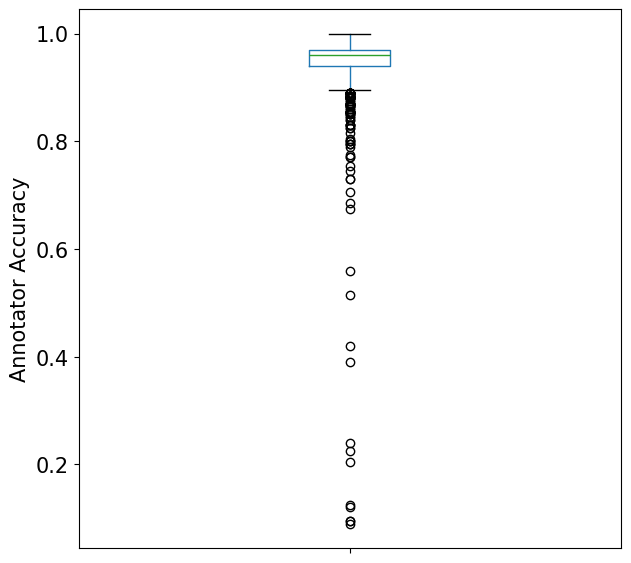

,score
0,0.920
1,0.955
2,0.955
3,0.945
4,0.960


In [5]:
c10h_annotator_mask = get_annotator_mask(c10h_labels)
c10h_labels_error_mask = get_labels_error_mask(c10h_labels, c10h_true_labels)
plt_annotator_accuracy(c10h_labels_error_mask, c10h_annotator_mask).head()

# Drop datapoints by selecting worst annotators

In [6]:
# Returns sample labels/error_mask/annotator_mask where x_drop, y_drop are idxs that are dropped
def get_sample_labels(x_drop, y_drop, labels, labels_error_mask, annotator_mask):
    s_annotator_mask = annotator_mask.copy()
    s_annotator_mask[(x_drop,y_drop)] = 0
    s_labels_error_mask = s_annotator_mask & labels_error_mask
    s_labels = labels.copy()
    np.copyto(s_labels, np.nan, where=(s_annotator_mask==0)) 
    print('Total idxs dropped: ', annotator_mask.sum() - s_annotator_mask.sum())
    return s_labels, s_labels_error_mask, s_annotator_mask

# Returns a list of labeled indices to drop (random length per row)
def get_random_drop_per_row(c10h_annotator_mask):
    x,y = np.where(c10h_annotator_mask == 1)
    idx_df = pd.DataFrame(zip(x,y),columns=['x','y'])
    for x_idx in range(idx_df['x'].max()+1):
        num_drop = np.random.randint(1, len(idx_df[idx_df['x'] == x_idx])+1)
        idx_df = idx_df.drop(idx_df[idx_df['x'] == x_idx].sample(num_drop).index)
    x_drop = idx_df['x'].values
    y_drop = idx_df['y'].values
    return x_drop, y_drop

# Returns a list of labeled indices to drop 
# (Randomly drop until <= max_annotations per example. Try to minimize number of distinct annotators)
def get_random_drop_per_row_min_annotators(c10h_annotator_mask, max_annotations = 5):
    x,y = np.where(c10h_annotator_mask == 1)
    xy = set([(x_idx,y_idx) for x_idx,y_idx in zip(x,y)])
    idx_df = pd.DataFrame(zip(x,y),columns=['x','y'])
    idx_keep = []
    selected_annotators = set()
    for x_idx in range(idx_df['x'].max()+1):
        Y = idx_df[idx_df['x'] == x_idx]['y']
        seen_annotators = set(Y).intersection(selected_annotators)
        if len(seen_annotators) < max_annotations: # We need to randomly select more annotators to greedy add
            num_to_find = max_annotations - len(seen_annotators)
            y_keep = set(np.random.choice(list(set(Y).difference(seen_annotators)), num_to_find, replace=False))
            selected_annotators = selected_annotators.union(y_keep)
            y_keep = seen_annotators.union(y_keep)
        else: # We have enough annotators and need to randomly select annotations out of the guys we have
            y_keep = np.random.choice(list(seen_annotators), max_annotations,replace=False)
        xy_keep = [(x_idx,y) for y in y_keep]
        idx_keep.extend(xy_keep)
    xy = xy.difference(set(idx_keep))
    x_drop = [xy_idx[0] for xy_idx in xy]
    y_drop = [xy_idx[1] for xy_idx in xy]
    return x_drop, y_drop

def get_worst_annotators(c10h_annotator_mask, annotator_idxs):
    annotations_per_example = np.zeros(c10h_annotator_mask.shape[0])
    annotations_per_annotator = np.zeros(c10h_annotator_mask.shape[1]) # dictionary of distinct examples
    selected_annotators = set()
    
    annotator_mask = np.zeros_like(c10h_annotator_mask)
    # add first x annotators
    num_initial_annotators = 25
    for idx in annotator_idxs[:num_initial_annotators]:
        x = np.where(c10h_annotator_mask[:,idx] == 1)[0]
        annotations_per_example[x] += 1
        annotations_per_annotator[idx] = len(x)
        selected_annotators.add(idx)
        annotator_mask[x, idx] = 1
    
    # only add other annotators if they share overlap with first x
    for idx in annotator_idxs[num_initial_annotators:]:
        if annotations_per_example.min() > 0:
            print('all examples have at least 1 annotator')
            break # test every single ex has at least 1 annotator
        
        x = np.where(c10h_annotator_mask[:,idx] == 1)[0] # annotator annotations
        
        # only add annotator if they overlap with current annotations
        if annotations_per_example[x].sum() > len(x):
            annotations_per_example[x] += 1
            annotations_per_annotator[idx] = len(x)
            selected_annotators.add(idx)
            annotator_mask[x, idx] = 1
    
    for ex in range(annotator_mask.shape[0]):
        if annotations_per_example[ex] < 3: # ignore dropping when there are very little annotations
            continue

        annotators = np.where(annotator_mask[ex] == 1)[0] # annotators for example
        drop_y = np.random.choice(annotators, len(annotators)-1, replace=False)

        for y in drop_y:
            if np.random.uniform() > 0.2:
                x = np.where(annotator_mask[:,y] == 1)[0]  # annotations for annotator y for all examples
                x = np.setdiff1d(x,np.array([ex])) # annotations for annotator y for all examples minus curent example
                if annotations_per_example[x].max() > 2: # number of total annotations by our annotator
                    annotator_mask[ex][y] = 0
                    annotations_per_annotator[y] -= 1
                    annotations_per_example[ex] -= 1

    x_drop, y_drop = np.where(annotator_mask == 0)
    
    print('num_worst_annotators_selected', len(selected_annotators))
    return x_drop, y_drop

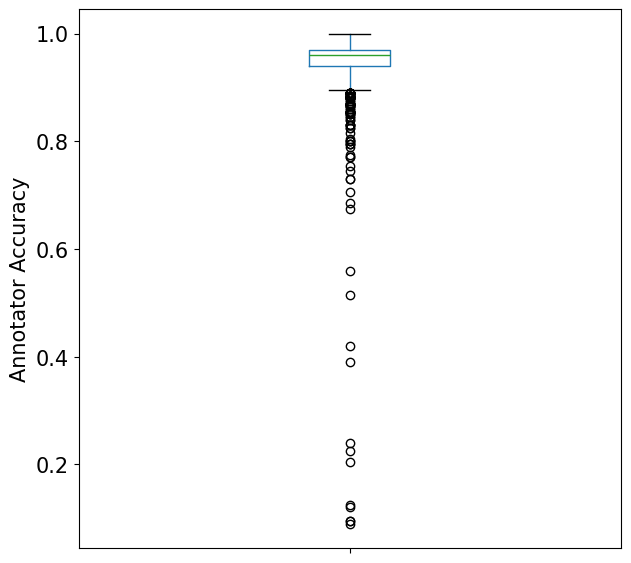

all examples have at least 1 annotator
num_worst_annotators_selected 511
Total idxs dropped:  485819
Make sure 10 <= max_annotations and 1 > 0: 
(10000, 511) (10000, 511)


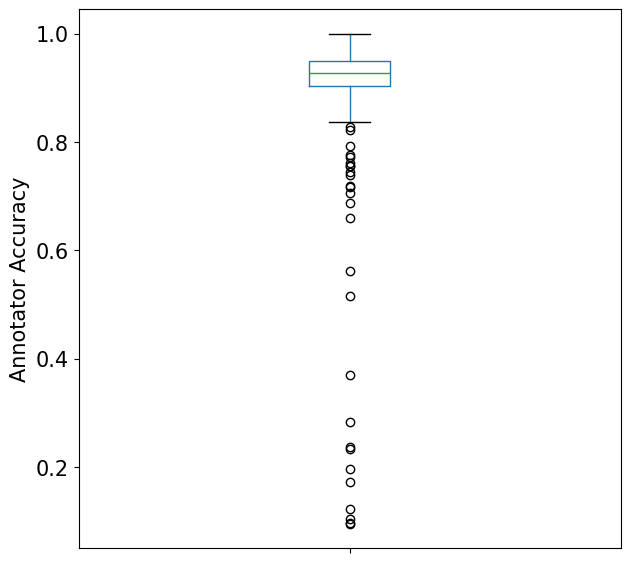

Consensus label accuracy:  0.9322


In [7]:
# get annotator accuracy
annotator_accuracy_df = plt_annotator_accuracy(c10h_labels_error_mask, c10h_annotator_mask).sort_values(by='score')
annotator_idxs = annotator_accuracy_df.index.values.tolist()

x_drop, y_drop = get_worst_annotators(c10h_annotator_mask, annotator_idxs)
c10h_labels, c10h_labels_error_mask, c10h_annotator_mask = \
                    get_sample_labels(x_drop, y_drop, c10h_labels, c10h_labels_error_mask, c10h_annotator_mask)

print(f'Make sure {c10h_annotator_mask.sum(axis=1).max()} <= max_annotations and { c10h_annotator_mask.sum(axis=1).min()} > 0: ')

# drop all empty annotators
drop_axis = c10h_labels.copy()
c10h_labels = c10h_labels[:, ~np.isnan(drop_axis).all(axis=0)]
c10h_labels_error_mask = c10h_labels_error_mask[:, ~np.isnan(drop_axis).all(axis=0)]
c10h_annotator_mask = c10h_annotator_mask[:, ~np.isnan(drop_axis).all(axis=0)]
print(c10h_labels.shape, c10h_annotator_mask.shape)

# get new annotator accuracy
annotator_accuracy_df = plt_annotator_accuracy(c10h_labels_error_mask,  c10h_annotator_mask).sort_values(by='score')
annotator_accuracy_df.describe()
consensus_labels = get_consensus_label(c10h_labels, pred_probs=None)
print('Consensus label accuracy: ', (c10h_true_labels == consensus_labels).sum() / 10000)

In [8]:
# Check if dataset creation conditions are met
for col in range(c10h_annotator_mask.shape[1]):
    annotator = np.where(c10h_annotator_mask[:,col] == 1)[0]
    intersects = False
    for j in range(c10h_annotator_mask.shape[1]):
        if j == col:
            continue
        annotator2 = np.where(c10h_annotator_mask[:,j] == 1)[0]
        if len(np.intersect1d(annotator, annotator2)) > 0:
            intersects = True
    if not intersects:
        print(f'annotator {col} does not intersect with any other annotator')

2     2929
3     2431
1     1716
4     1614
5      830
6      307
7      127
8       34
9        9
10       2
12       1
dtype: int64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

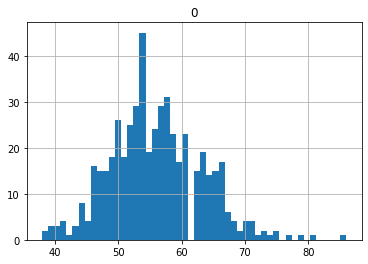

In [9]:
# Get stats
print(pd.DataFrame(c10h_annotator_mask.sum(axis=1)).value_counts())
pd.DataFrame(c10h_annotator_mask.sum(axis=0)).hist(bins=50)

In [11]:
# Check annotator similarity
similarity = np.matmul(c10h_annotator_mask.T,c10h_annotator_mask)
np.fill_diagonal(similarity, 0)
print(similarity.shape)
ax = sns.heatmap(similarity, square=True)

(511, 511)


In [16]:
# Directory where the files will be saved
save_directory = './data/benchmark_data/'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save labels and true images/labels as npy
np.save(os.path.join(save_directory, 'c10h_labels'), c10h_labels)
np.save(os.path.join(save_directory, 'c10h_true_labels'), c10h_true_labels)
np.save(os.path.join(save_directory, 'c10h_true_images'), c10h_true_images)

In [17]:
# Save labels as csv with image paths
mini_df = c10h_df[['image_filename','true_category','cifar10_test_test_idx']].drop_duplicates()
image_locs = [path + 
              '/data/cifar10/test/' +
              mini_df[mini_df['image_filename'] == c10h_true_images[i]]['true_category'].item() +
              '/test_batch_index_' +
              str(mini_df[mini_df['image_filename'] == c10h_true_images[i]]['cifar10_test_test_idx'].item()).zfill(4) +
              '.png'
              for i in range(len(c10h_true_images))]
consensus_df = pd.DataFrame(zip(image_locs, consensus_labels), columns=['image', 'label'])
consensus_df.to_csv('./data/benchmark_data/cifar10_test_consensus_dataset.csv', index=False)

#### Cifar-10h dataset attribution
Peterson, J.*, Battleday, R.*, Griffiths, T., & Russakovsky, O. (2019).
    Human uncertainty makes classification more robust.
    In Proceedings of the IEEE International Conference on Computer Vision.